# (84100) Farnocchia orbit determination test

In [1]:
import grss
prop = grss.prop
fit = grss.fit

In [2]:
import numpy as np
np.set_printoptions(precision=40, linewidth=np.inf)
import matplotlib.pyplot as plt

In [3]:
body_id = '84100'
init_sol, init_cov, nongrav_info = fit.get_sbdb_info(body_id)
body_radius = 0.0

In [4]:
optical_obs_file = None
t_min_tdb = None
t_max_tdb = None
debias = False
debias_lowres = True
deweight = True
eliminate = False
max_obs_per_night = 4
verbose = True
obs_array_optical, observer_codes_optical = fit.get_optical_obs_array(body_id, optical_obs_file, t_min_tdb, t_max_tdb, debias, debias_lowres, deweight, eliminate, max_obs_per_night, verbose)
obs_array_radar, observer_codes_radar = fit.get_radar_obs_array(body_id, t_min_tdb, t_max_tdb, verbose)

Skipped 21 observations 
	 21 of which were non-geocentric occultations or space-based observations, 
	 0 were either roving or radar observations (radar is handled separately), 
	 0 of which were outside the specified time range.
No debiasing needed for 505 observations. Debiased 417 observations. No biasing information for 0 observations.
Applied default weight of 1 arcsec to 38 CCD observations
Deweighted 208 observations as part of deweighting scheme.


In [5]:
n_iter_max = 10
de_kernel = 441
de_kernel_path = grss.utils.default_kernel_path(de_kernel)
fit_sim = fit.FitSimulation(init_sol, init_cov, obs_array_optical, observer_codes_optical, obs_array_radar, observer_codes_radar, n_iter_max=n_iter_max, de_kernel=de_kernel, de_kernel_path=de_kernel_path, radius=body_radius, nongrav_info=nongrav_info)

In [6]:
fit_sim.filter_lsq()

Iteration		Unweighted RMS		Weighted RMS 		Chi-squared		Reduced Chi-squared
1			 0.428			 0.530			 518.657			 0.282
2			 0.428			 0.530			 518.235			 0.282
Converged without rejecting outliers. Starting outlier rejection now.
3			 0.393			 0.490			 439.901			 0.241
4			 0.393			 0.490			 439.764			 0.241
Converged after rejecting outliers.


In [7]:
fit_sim.print_summary()

Summary of the orbit fit calculations at iteration 4 (of 4):
RMS unweighted: 0.39314188132605554
RMS weighted: 0.4896774755007317
chi-squared: 439.7639110434197
reduced chi-squared: 0.24057106731040465
square root of reduced chi-squared: 0.4904804453904403
t: MJD 57900.0 TDB
Fitted Variable		Initial Value			Uncertainty			Fitted Value 			Uncertainty			Change				Change (sigma)
e			2.02922458015e-01		3.51842031434e-08 		2.02922457346e-01		3.44829807669e-08 		-6.69466537762e-10		-0.019
q			2.17573385967e+00		9.43400203799e-08 		2.17573386152e+00		9.26483150001e-08 		+1.85316251233e-09		+0.020
tp			5.74183571490e+04		3.77402663480e-05 		5.74183571444e+04		3.55718892995e-05 		-4.56755515188e-06		-0.121
om			1.52357330368e+02		3.65881788601e-05 		1.52357322980e+02		3.61051560456e-05 		-7.38838815550e-06		-0.202
w			2.08343130337e+02		3.75791928400e-05 		2.08343136301e+02		3.69436401424e-05 		+5.96428114363e-06		+0.159
i			5.81863574787e+00		3.66657233129e-06 		5.81863701450e+00		3.52859223080

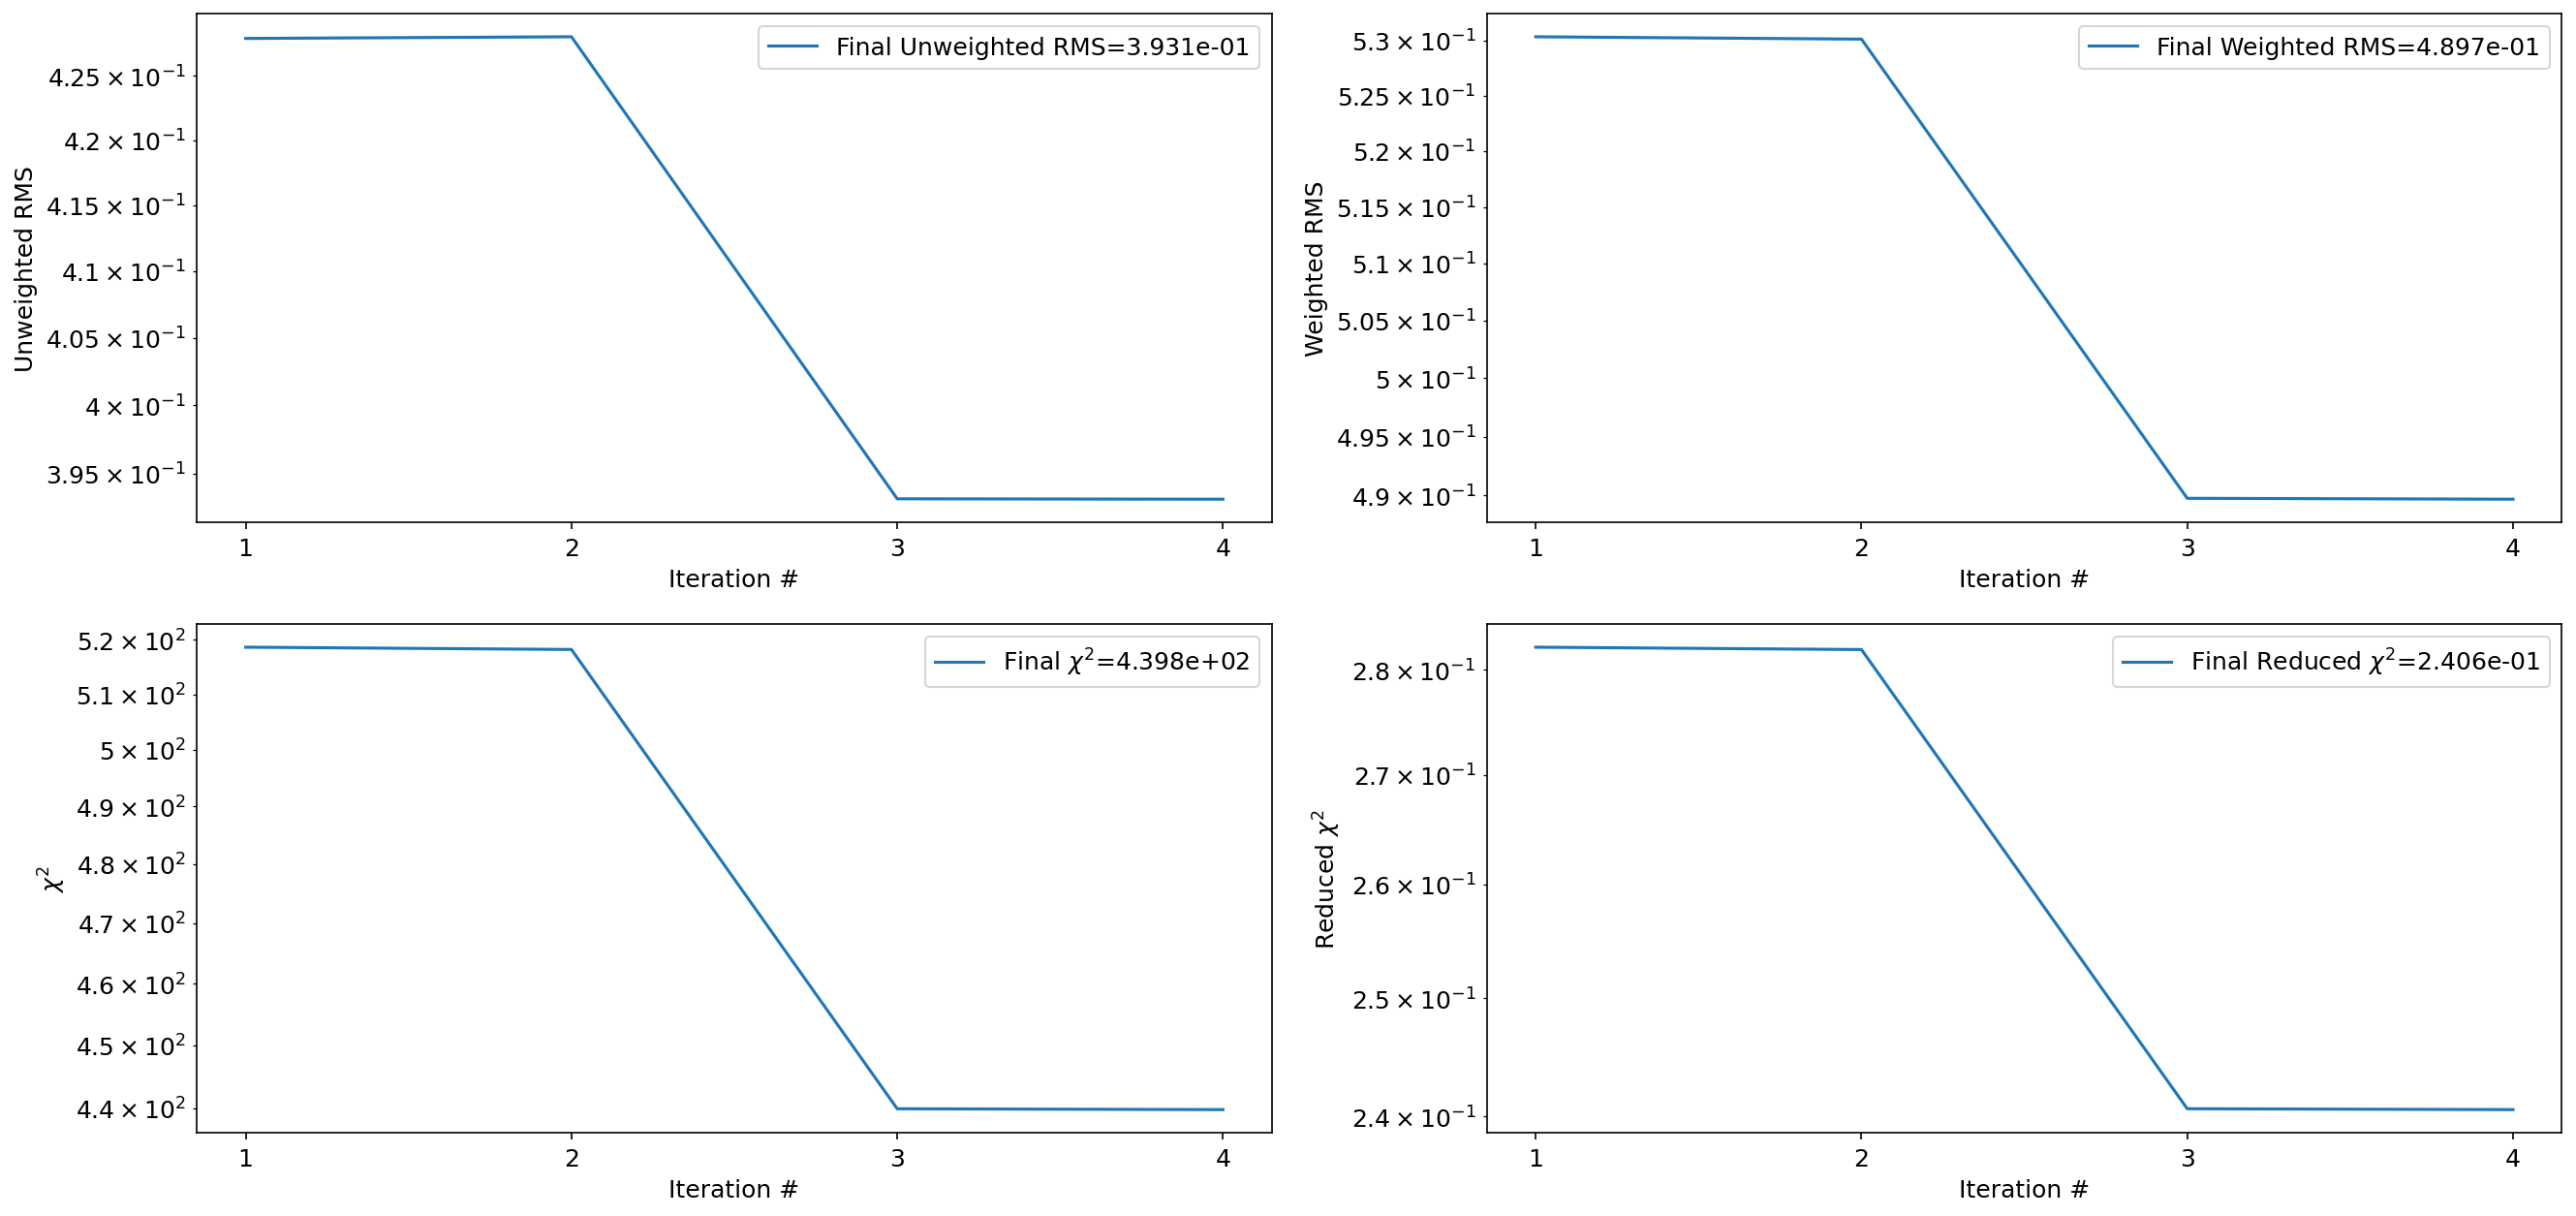

In [8]:
fit_sim.plot_summary(auto_close=True)

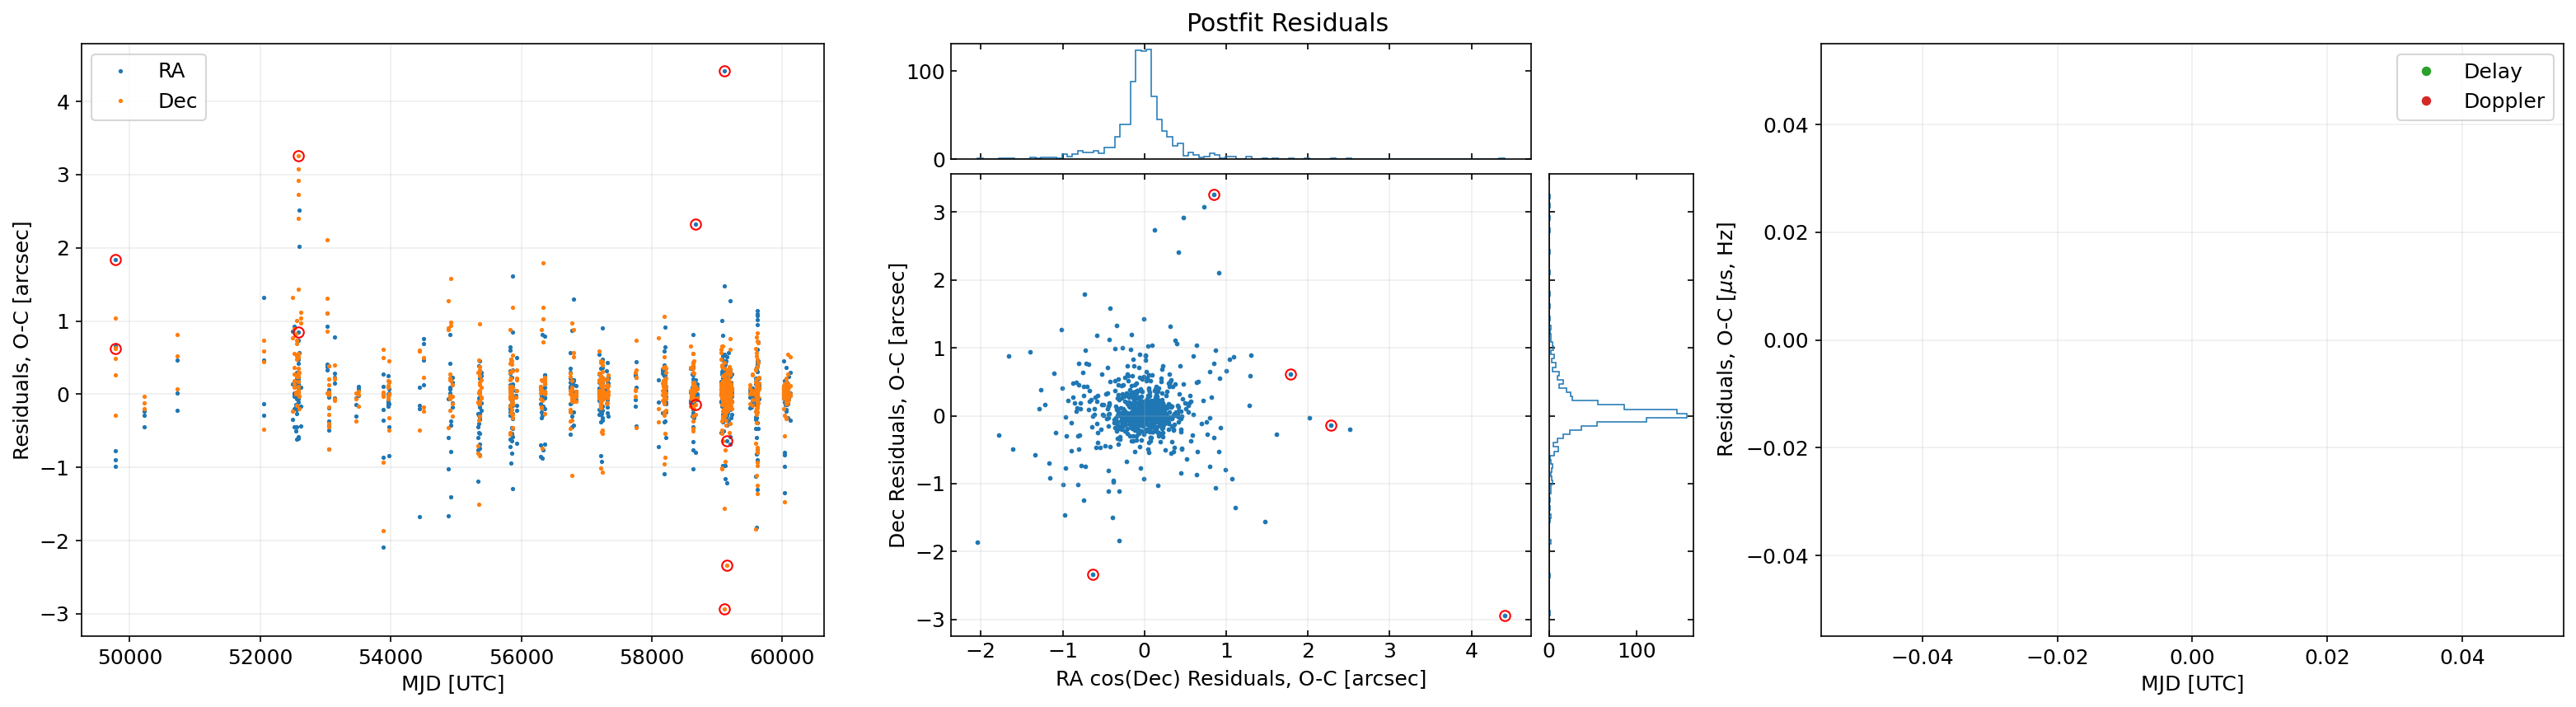

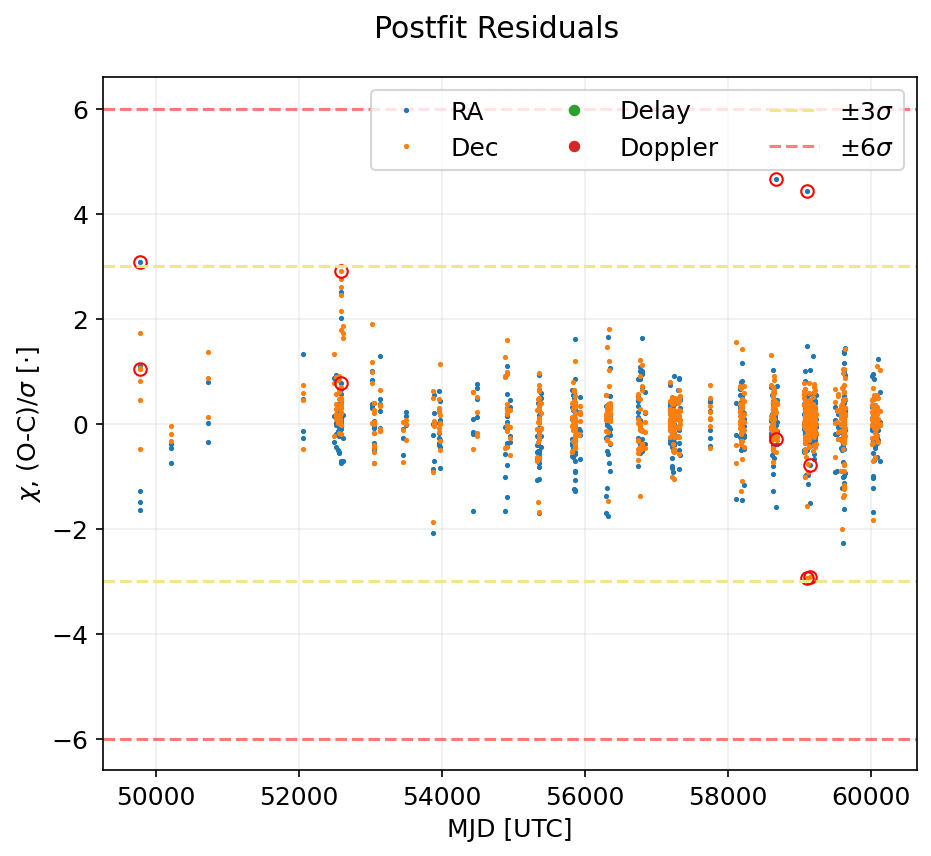

In [9]:
fit_sim.iters[-1].plot_iteration_summary(title='Postfit Residuals', auto_close=True)

In [10]:
mean_0 = np.array(list(init_sol.values())[1:])
cov_0 = init_cov
mean_f = np.array(list(fit_sim.x_nom.values()))
cov_f = fit_sim.covariance

maha_dist_f, maha_dist_0, bhattacharya, bhatt_coeff = fit.get_similarity_stats(mean_0, cov_0, mean_f, cov_f)
print(f'Mahalonobis distance between JPL and GRSS solution: {maha_dist_f:0.2f}')
print(f'Mahalonobis distance between GRSS and JPL solution: {maha_dist_0:0.2f}')
print(f'Bhattacharya distance between JPL and GRSS solution: {bhattacharya:0.4f}')
print(f'Bhattacharya coefficient between JPL and GRSS solution: {bhatt_coeff:0.4f}')

Mahalonobis distance between JPL and GRSS solution: 0.45
Mahalonobis distance between GRSS and JPL solution: 0.48
Bhattacharya distance between JPL and GRSS solution: 0.0065
Bhattacharya coefficient between JPL and GRSS solution: 0.9935


In [11]:
assert maha_dist_f < 3.0
assert maha_dist_0 < 3.0
assert bhattacharya < 0.10
assert bhatt_coeff > 0.90